# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import warnings; warnings.simplefilter('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [107]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [108]:
# Describe the azdias dataset
azdias.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486466,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [109]:
# Display count of rows and columns
azdias.shape

(891221, 367)

In [110]:
# Describe the customers dataset
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [111]:
# Display azdias first rows
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [112]:
# Display count of rows and columns
customers.shape

(191652, 369)

In [113]:
def plot_null_ratio(df, name):
    """
    plotting the NaN ratio & proportion of a data set of columns
    Input:
        df = dataset to be analyzed
        name = name of the dataset
    Output:
        Plot of the NaN ratio & proportion
    """
    plt.subplots_adjust(hspace=4.0, top = 0.9)
    df_isnull = df.isnull().sum()
    df_isnull_perc = df_isnull / len(df) * 100

    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax = df_isnull_perc.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(15,15), title='Columns with highest Null ratio in {}'.format(name))
    ax.set_xlabel("Attribute azdias")
    ax.set_ylabel("Ratio of Null [%]")
    
    ax = fig.add_subplot(212)
    plt.hist(df_isnull_perc, bins=20);
    plt.xlabel('Proportion of NaN Values in the Feature/Column')
    plt.ylabel('Number of Features/Columns in {}'.format(name))
    plt.title('Proportion of NaN Values in {} Columns'.format(name))
    plt.subplots_adjust(hspace=1.0)
    


<Figure size 432x288 with 0 Axes>

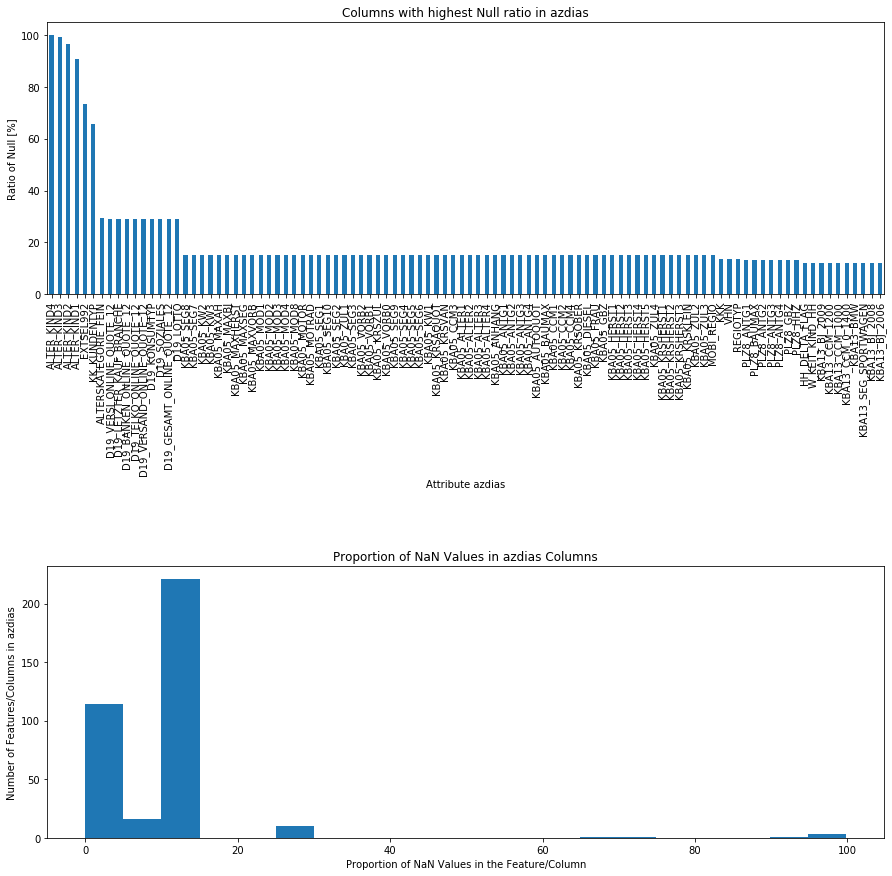

In [114]:
plot_null_ratio(azdias, 'azdias')

<Figure size 432x288 with 0 Axes>

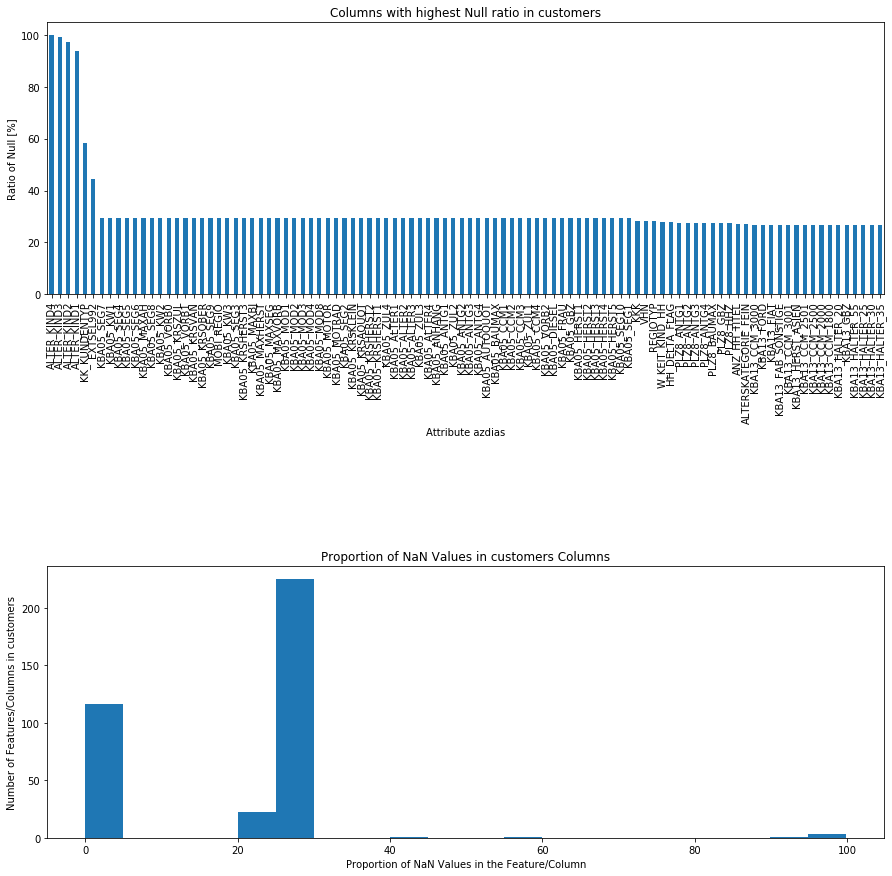

In [115]:
plot_null_ratio(customers, 'customers')

In [116]:
def col_to_drop(df, limit_perc):
    """
    Output of the columns to be deleted
    Input:
        df = dataset to be analyzed
        limit_perc = limit in percent
    Output:
        columns to drop
    """
    df_null = df.isnull().sum()
    df_null_perc = df_null / len(df) * 100
    df_null_perc = df_null_perc[df_null_perc > limit_perc].index
    return df_null_perc
    

In [117]:
col_to_drop(azdias, 20)

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')

In [118]:
# display of columns which are not present in azdias
(set(customers.columns.values) - set(azdias.columns.values))


{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [15]:
# upload and simple adjustments of the dataset 'DIAS Information Levels - Attributes 2017.xlsx'
attribuets_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
attribuets_desc.drop('Unnamed: 0', axis=1, inplace=True)
attribuets_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [16]:
# upload and simple adjustments of the dataset 'DIAS Attributes - Values 2017.xlsx'
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
attributes_values.drop(columns=['Unnamed: 0'], inplace=True)
attributes_values['Attribute'] = attributes_values['Attribute'].fillna(method='ffill')
attributes_values['Description'] = attributes_values['Description'].fillna(method='ffill')
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [121]:
# output of the overlapping attributes
customers_unique = set(list(customers.columns))
azdias_unique = set(list(azdias.columns))
attribuets_desc_unique = set(list(attribuets_desc.Attribute))
attributes_values_unique = set(list(attributes_values.Attribute))
common_attributes = customers_unique & azdias_unique & attribuets_desc_unique & attributes_values_unique
common_attributes

{'AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'HH_EINKOMMEN_SCORE',
 'INNENSTADT',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4'

In [122]:
# display of the overlapping attributes
columns_not_described = list(set(azdias) - set(common_attributes))
columns_not_described

['ALTER_KIND3',
 'KBA13_CCM_1401_2500',
 'STRUKTURTYP',
 'D19_VERSAND_REST',
 'D19_DIGIT_SERV',
 'D19_FREIZEIT',
 'CJT_TYP_3',
 'D19_VERSICHERUNGEN',
 'D19_BUCH_CD',
 'D19_BEKLEIDUNG_GEH',
 'VK_ZG11',
 'KBA13_CCM_3000',
 'D19_VERSAND_ANZ_24',
 'D19_TECHNIK',
 'CJT_TYP_5',
 'D19_SCHUHE',
 'D19_GESAMT_ANZ_12',
 'VHA',
 'RT_KEIN_ANREIZ',
 'ALTER_KIND4',
 'DSL_FLAG',
 'GEMEINDETYP',
 'VERDICHTUNGSRAUM',
 'D19_GARTEN',
 'EXTSEL992',
 'D19_VERSI_ONLINE_QUOTE_12',
 'KBA13_BAUMAX',
 'CJT_TYP_1',
 'MOBI_RASTER',
 'D19_VERSI_ANZ_12',
 'CJT_TYP_2',
 'D19_VERSI_DATUM',
 'D19_LEBENSMITTEL',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_LOKAL',
 'HH_DELTA_FLAG',
 'D19_LETZTER_KAUF_BRANCHE',
 'ALTER_KIND2',
 'KBA13_CCM_3001',
 'D19_LOTTO',
 'CJT_KATALOGNUTZER',
 'AKT_DAT_KL',
 'D19_TELKO_ANZ_24',
 'D19_RATGEBER',
 'UNGLEICHENN_FLAG',
 'SOHO_KZ',
 'VHN',
 'D19_BANKEN_ANZ_12',
 'KBA13_ANTG3',
 'D19_VERSI_ANZ_24',
 'KK_KUNDENTYP',
 'D19_SOZIALES',
 'D19_HAUS_DEKO',
 'D19_BANKEN_ANZ_24',
 'ALTER_KIND1',
 'VK_DHT4A'

In [123]:
# representation of the dtypes in azdias
azdias.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [124]:
# number of unique attributes 'D19_LETZTER_KAUF_BRANCHE'
len(azdias['D19_LETZTER_KAUF_BRANCHE'].unique())

36

In [125]:
# number of unique attributes 'EINGEFUEGT_AM'
len(azdias['EINGEFUEGT_AM'].unique())

5163

In [126]:
# number of unique attributes 'OST_WEST_KZ'
len(azdias['OST_WEST_KZ'].unique())

3

In [127]:
# customizing the attributes values dataset with the meaning unknown and creating the array for the values
attributes_values_copy =attributes_values.copy()
attributes_values_copy['Meaning'].fillna('unknown', inplace=True)
attributes_values_unknown = attributes_values_copy[attributes_values_copy['Meaning'].str.contains("unknown")]
attributes_values_unknown['Value'] = attributes_values_unknown.Value.apply(lambda x: str(x).split(','))
attributes_values_unknown

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1],unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
11,ALTER_HH,main age within the household,[0],unknown / no main age detectable
33,ANREDE_KZ,gender,"[-1, 0]",unknown
40,BALLRAUM,distance to next urban centre,[-1],unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"[-1, 0]",unknown
2229,WOHNLAGE,residential-area,[-1],unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"[-1, 0]",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"[-1, 0]",unknown


# Data Cleaning

In [50]:
def data_cleaning(df, df_name=None):
    """
    summary of findings on data cleansing
    Input:
        df = dataset to be cleaned
        df_name = name of dataset
    Output:
        Prepared dataset
    """
    
    #Dropping columns with more than twenty percent nulls in azdias
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
    df = df.drop(drop_cols,axis=1)
    
    #Filtering unique columns in customers dataset
    if df_name == 'customers':            
        df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    
    #Dropping columns that are not described in DIAS Information Levels & Values.xlsx
    attribuets_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
    
    attribuets_desc.drop('Unnamed: 0', axis=1, inplace=True)
    attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
    attributes_values.drop('Unnamed: 0', axis=1, inplace=True)
    attribuets_desc_unique = set(list(attribuets_desc.Attribute))
    attributes_values_unique = set(list(attributes_values.Attribute))
    common_attributes = attribuets_desc_unique & attributes_values_unique
    columns_not_described = list(set(df) - set(common_attributes))
    df.drop(labels=columns_not_described, axis=1, inplace=True)
    
    # Replacing unknown Values with Null
    
    attributes_values['Meaning'].fillna('unknown', inplace=True)
    attributes_values_unknown = attributes_values[attributes_values['Meaning'].str.contains("unknown")]
    attributes_values_unknown['Value'] = attributes_values_unknown.Value.apply(lambda x: str(x).split(','))
    for column in df:
        try:
            index = attributes_values_unknown.index[attributes_values_unknown['Attribute']==column].tolist()[0]
            m = df[column].isin(attributes_values_unknown['values'][index])
            df[column] = df[column].mask(m, np.nan)
        except:
            continue

    
    #Dropping rows with more than twenty percent nulls in azdias
    #null_perc_row = df.isnull().mean(axis=1)
    #df = df[null_perc_row < 0.2]
    
    # Re-encode Features:
    df[['CAMEO_DEUG_2015']] = df[['CAMEO_DEUG_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015']] = df[['CAMEO_DEUG_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015']] = df[['CAMEO_DEUG_2015']].astype(int)
    df[['OST_WEST_KZ', 'CAMEO_DEU_2015']]=df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    # Get dummies
    df = pd.get_dummies(df)
    df_columns = list(df.columns.values)
    
    #Impute
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    
    return df
    

In [51]:
# implementation of the data preparation for customers
customers_prep = data_cleaning(customers, 'customers')

In [52]:
# implementation of the data preparation for azdias
azdias_prep = data_cleaning(azdias, 'azdias')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [131]:
def sklearn_pca(df, components=None):
    pca = PCA(components)
    data_transformed = pca.fit_transform(df)
    return pca, data_transformed

In [132]:
customers_pca_model, pca_transformed = sklearn_pca(customers_prep, 150)

In [133]:
def plot_pca(df, Name=None):
    """
    Principal Component Analysis
    Input:
        df = dataset to be analyzed
        Name = name of dataset
    Output:
        plot of PCA
    """
    pca = PCA()
    customers_pca = pca.fit_transform(df)

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Explained Variance - Scree Plot {}'.format(Name))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(b=True)

    plt.show()

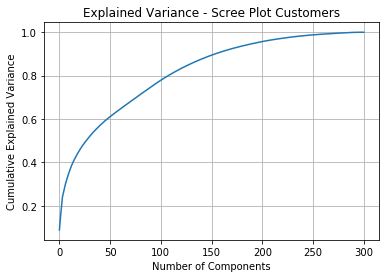

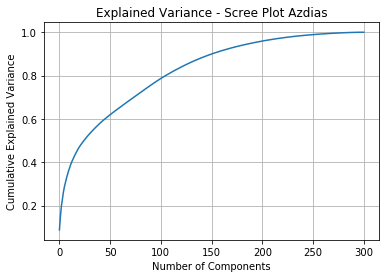

In [134]:
# Plotting pca for the datasets customers & azdias
plot_pca(customers_prep, 'Customers')
plot_pca(azdias_prep, 'Azdias')

In [7]:
def reduce_data(df,n=None):
    """
    reduction of data by component
    Input:
        df = dataset to be analyzed
        n = number of components
    Output:
        reduced dataset
    """
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data, pca

In [23]:
customers_red, pca_customers = reduce_data(customers_prep, 150)
azdias_red, pca_azdias = reduce_data(azdias_prep, 150)

0.9400019916097493
0.943269715710234


In [137]:
def elbow_method(df, Name=None):
    """
    Plot of the elbow method
    Input:
        df = dataset to be analyzed
        Name = name of dataset
    Output:
        plot of elbow method
    """
    points = np.array([])
    K = range(1,15)
    for k in K:    
        kmeans = KMeans(k)
        km = kmeans.fit(df)
        points = np.append(points, np.abs(km.score(df)))
        
    plt.plot(K, points, linestyle='-', marker='x', color='blue')
    plt.xlabel('K')
    plt.ylabel('SSE Score')
    plt.title('Elbow Graph - {}'.format(Name))
    plt.show()

In [ ]:
# plotting elbow method for customers & azdias data
elbow_method(customers_red, 'Customers')
elbow_method(azdias_red, 'Azdias')

In [9]:
def kmeans_cluster(df, k=None):
    """
    Plot of the elbow method
    Input:
        df = dataset to be analyzed
        k = number of clusters
    Output:
        predictions model according to kmeans
    """
    kmeans_k = KMeans(n_clusters=k)
    model_k = kmeans_k.fit(df)
    df = model_k.predict(df)

    return df, kmeans_k

In [24]:
# Implementation of predictions model according to kmeans for customers & azdias dataset
customers_predict, kmeans_customers = kmeans_cluster(customers_red, 12)
azdias_predict, kmeans_azdias = kmeans_cluster(azdias_red, 12)

In [25]:
def cluster_plot(df1, df2, df1_name=None, df2_name=None):
    """
    Plot of the ratio for each cluster for two datasets & display of data
    Input:
        df1 = first dataset to be analyzed
        df2 = scoud dataset to be analyzed
        df1_name = name of first dataset to be analyzed
        df2_name = name of scoud dataset to be analyzed
    Output:
        Plot & display of the ratio for each cluster
    """
    df1 = pd.Series(df1, name='{}'.format(df1_name))
    df1 = df1.value_counts().sort_index()
    df2 = pd.Series(df2, name='{}'.format(df2_name))
    df2 = df2.value_counts().sort_index()
    
    df = pd.concat([df2, df1], axis=1).reset_index()
    df.columns = ['cluster','{}'.format(df2_name),'{}'.format(df1_name)]

    df['Perct of {}'.format(df2_name)] = (df['{}'.format(df2_name)] / (df['{}'.format(df2_name)].sum()) * 100 ).round(2)
    df['Perct of {}'.format(df1_name)] = (df['{}'.format(df1_name)] / (df['{}'.format(df1_name)].sum()) * 100 ).round(2)
    
    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(111)

    ax = df['Perct of {}'.format(df2_name)].plot(x=df['cluster'], width=-0.3, align='edge', color='blue', kind='bar', position=0)
    ax = df['Perct of {}'.format(df1_name)].plot(kind='bar', color='grey', width = 0.3, align='edge', position=1)

    ax.set_xlabel('Clusters', fontsize=15) 
    ax.set_ylabel('Ratio [%]', fontsize=15)

    ax.xaxis.set(ticklabels=range(20))
    ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    ax.margins(x=0.5,y=0.1)

    plt.legend(('{}'.format(df2_name), '{}'.format(df1_name)), fontsize=15)
    plt.title(('Percentege of Azdias & Customer in each cluster'))

    plt.show()
    return df

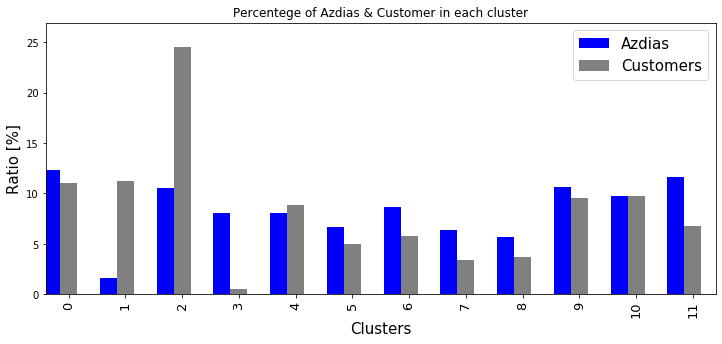

,cluster,Azdias,Customers,Perct of Azdias,Perct of Customers
0,0,109799,21100,12.32,11.01
1,1,14786,21553,1.66,11.25
2,2,94143,46977,10.56,24.51
3,3,72218,933,8.10,0.49
4,4,71821,16969,8.06,8.85
5,5,59139,9469,6.64,4.94
6,6,76880,11114,8.63,5.80
7,7,56627,6492,6.35,3.39
8,8,50692,7112,5.69,3.71
9,9,94428,18225,10.60,9.51


In [26]:
# plotting percentege of azdias & customer in each cluster
cluster_plot(customers_predict, azdias_predict, df1_name='Customers', df2_name='Azdias')

In [27]:
def combine_info(df_prep, df_red, kmeans, pca, cluster): #n, k, cluster):
    """
    Plot of the ratio for each cluster for two datasets & display of data
    Input:
        df_prep = first dataset to be analyzed
        df_red = scoud dataset to be analyzed
        n = name of first dataset to be analyzed
        k = name of scoud dataset to be analyzed
        cluster = 
    Output:
        Plot & display of the ratio for each cluster
    """   
    df = dict(zip(df_prep.columns, pca.inverse_transform(kmeans.cluster_centers_[cluster])))
    df = pd.DataFrame.from_dict(df, orient='index', columns=['Values']).sort_values(by='Values')
    df['Description'] = np.nan
    for index, row in attribuets_desc.iterrows():
        index_val = row['Attribute']
        df.loc[df.index == index_val, "Description"] = row['Description']
        
    print(df.sort_values(by='Values', ascending=False))

In [28]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
combine_info(customers_prep, customers_red, kmeans_customers, pca_customers, 2)

                               Values  \
FINANZ_ANLEGER               1.494176   
FINANZ_UNAUFFAELLIGER        1.473982   
FINANZ_SPARER                1.456437   
SEMIO_REL                    1.379579   
KBA13_ANZAHL_PKW             1.221558   
SEMIO_KRIT                   1.135870   
D19_GESAMT_DATUM             1.060814   
CJT_GESAMTTYP                1.054164   
SEMIO_PFLICHT                1.000871   
SEMIO_KAEM                   0.954174   
SEMIO_DOM                    0.913484   
D19_VERSAND_DATUM            0.913041   
SEMIO_FAM                    0.902379   
D19_GESAMT_ONLINE_DATUM      0.816972   
REGIOTYP                     0.780586   
MOBI_REGIO                   0.779875   
KBA05_MAXBJ                  0.777718   
D19_VERSAND_ONLINE_DATUM     0.757963   
D19_GESAMT_OFFLINE_DATUM     0.723522   
W_KEIT_KIND_HH               0.710652   
KBA05_MAXAH                  0.706154   
D19_VERSAND_OFFLINE_DATUM    0.657303   
SEMIO_RAT                    0.649122   
BALLRAUM        

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [61]:
# Loading the train data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [63]:
# Head of train dataframe
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [64]:
# Count of rows & columns of train dataset
mailout_train.shape

(42962, 368)

In [65]:
# Cleaning the data and concat the column 'RESPONSE'
mailout_train_clean = pd.concat([data_cleaning(mailout_train.drop(['RESPONSE'], axis=1), 'mailout_train'), mailout_train['RESPONSE']], axis=1)

In [66]:
# Building the X and y dataset
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [67]:
# Count of rows & columns of clean train dataset
mailout_train_clean.shape

(42962, 302)

In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.
    In accordance with: https://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Train score = {}".format(train_scores_mean[-1].round(3)))
    print("Validation score = {}".format(test_scores_mean[-1].round(3)))
    param_grid = {}
    gridcv = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='roc_auc')
    gridcv.fit(X, y)
    print("GritCv score = {}".format(gridcv.best_score_.round(3)))
    pass
    return plt




Train score = 0.778
Validation score = 0.776
GritCv score = 0.539


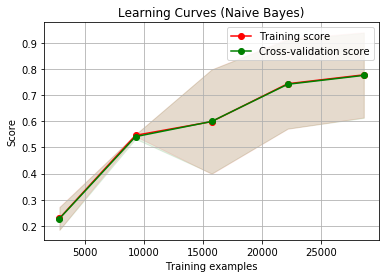

In [34]:
title = "Learning Curves (Naive Bayes)"
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y);

Train score = 0.995
Validation score = 0.988
GritCv score = 0.491


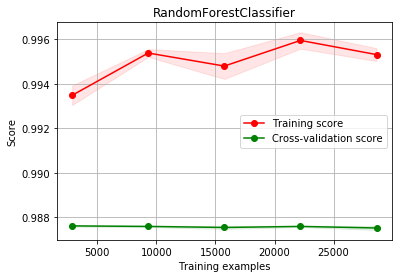

In [35]:
title = "RandomForestClassifier"
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y);

Train score = 0.988
Validation score = 0.986
GritCv score = 0.547


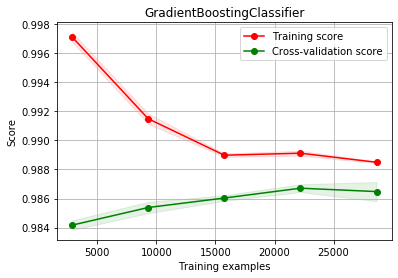

In [36]:
title = "GradientBoostingClassifier"
estimator = GradientBoostingClassifier()
plot_learning_curve(estimator, title, X, y);

Train score = 0.988
Validation score = 0.988
GritCv score = 0.541


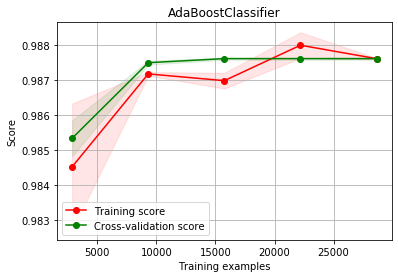

In [37]:
title = "AdaBoostClassifier"
estimator = AdaBoostClassifier()
plot_learning_curve(estimator, title, X, y);

Train score = 0.988
Validation score = 0.988
GritCv score = 0.54


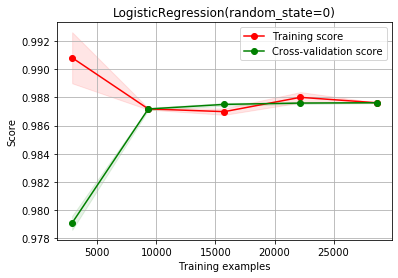

In [38]:
LogisticRegression(random_state=0)
title = "LogisticRegression(random_state=0)"
estimator = LogisticRegression(random_state=0)
plot_learning_curve(estimator, title, X, y);

Train score = 0.998
Validation score = 0.971
GritCv score = 0.5


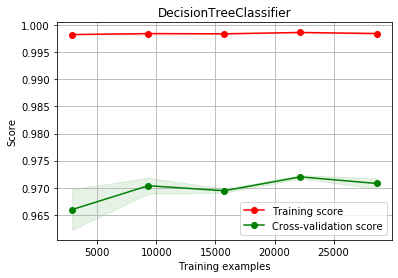

In [39]:
DecisionTreeClassifier
title = "DecisionTreeClassifier"
estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, title, X, y);

Train score = 0.998
Validation score = 0.988
GritCv score = 0.538


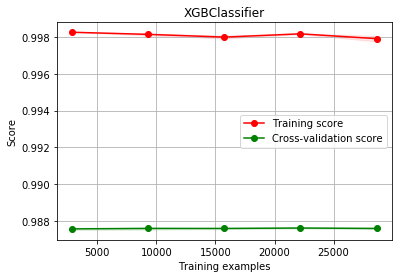

In [40]:
title = "XGBClassifier"
estimator = xgb.XGBClassifier(eval_metric = 'auc')
plot_learning_curve(estimator, title, X, y);

In [91]:
xgb.XGBClassifier(eval_metric = 'auc').get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
       gamma=None, gpu_id=None, importance_type='gain',
       interaction_constraints=None, learning_rate=None,
       max_delta_step=None, max_depth=None, min_child_weight=None,
       missing=nan, monotone_constraints=None, n_estimators=100,
       n_jobs=None, num_parallel_tree=None, objective='binary:logistic',
       random_state=None, reg_alpha=None, reg_lambda=None,
       scale_pos_weight=None, subsample=None, tree_method=None,
       use_label_encoder=True, validate_parameters=None, verbosity=None)>

In [54]:
param_grid = {
    'n_estimators': [25, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [5, 10, 15],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
}

gridcv = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric = 'auc'), param_grid=param_grid, scoring='roc_auc')
gridcv.fit(X, y)
print(gridcv.best_score_)
print(gridcv.best_estimator_)

0.5726667034648691
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=50, n_jobs=8,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=1.3, reg_lambda=1.2, scale_pos_weight=1, subsample=1,
       tree_method='exact', use_label_encoder=True, validate_parameters=1,
       verbosity=None)


In [74]:
# Saving the optimized model
clf = xgb.XGBClassifier(eval_metric = 'auc', n_estimators=50, colsample_bytree=0.8, learning_rate=0.3, max_depth=5, reg_alpha=1.3, reg_lambda=1.2  )
clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.3, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=50, n_jobs=8,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=1.3, reg_lambda=1.2, scale_pos_weight=1, subsample=1,
       tree_method='exact', use_label_encoder=True, validate_parameters=1,
       verbosity=None)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [71]:
# Separation of the column 'LNR' in diffrent dataframe
LNR = mailout_test['LNR']

In [72]:
# Cleaning the test_data
mailout_test_clean = data_cleaning(mailout_test, 'mailout_test')

In [75]:
# Modeling the prediction
y_pred = clf.predict_proba(mailout_test_clean)

In [76]:
# Making the final dataframe for submission
df_sub = pd.concat([pd.DataFrame(LNR), pd.DataFrame(y_pred)], axis=1)
df_sub = df_sub[['LNR', 1]]
df_sub.rename(columns={1: "RESPONSE"}, inplace=True)

In [77]:
# Display the final dataframe
df_sub.head()

,LNR,RESPONSE
0,1754,0.042309
1,1770,0.006460
2,1465,0.028149
3,1470,0.004043
4,1478,0.005412


In [78]:
# Transforming the data frame to csv
df_sub.to_csv('submission.csv', index=False)